In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np
from scipy import stats

import datetime as dt 
from scipy.stats import kendalltau, pearsonr, spearmanr
import math
from scipy.stats import gamma
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import bernoulli
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.distributions.empirical_distribution import ECDF
# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.gridspec import GridSpec
from IPython.display import display, Markdown, Latex, HTML
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import Markdown as md


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}


# # use these to format date axis in charts
# weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
# # onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
# # everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

# months = mdates.MonthLocator(bymonth=[3,6,9,12])
# bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
# allmonths = mdates.MonthLocator()
# wks_fmt = mdates.DateFormatter('%d')
# mths_fmt = mdates.DateFormatter('%b')

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# map marker size:
markerSize = 100
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date ='2021-04-01'

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False


# collect the names:
# group_names = list(these_groups.keys())

# choose a lake:
# lake = 'Lac Léman'
coi = 'Neuchâtel'
bassin_label = 'Aare'
bassin = ['Aare', 'Aare|Nidau-Büren-Kanal','Schüss', 'Neuenburgersee', 'Thunersee','Bielersee', 'Brienzersee','La Thièle']
bassin_lmn = ['Rhône', 'Lac Léman']
coi_lmn = 'Vevey'
bassin_lmn_label = "Rhône - Léman"
samples_all = 'All samples'
# lavey_locs= ['lavey-les-bains-2','lavey-les-bains', 'lavey-la-source']


# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'bielsummary'
save_output = False

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# get the data
# aggregated survey data
# dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")

# keep track of output
files_generated = []
figure_num = 1
data_num = 1

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

## <span style="color:#008891">Get data, assign initial variables run initial checks</span>

In [3]:
# non aggregated survey data
# Zero values are assigned for all codes not identified at a survey, for each survey
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# dimensional data
dfDims = pd.read_csv(F"{survey_data}/dims_data.csv")

# project lakes and beaches:

with open(F"{location_data}/project_lakes.json", "r") as a_file:
    project_lakes = json.load(a_file)
with open(F"{location_data}/project_beaches.json", "r") as a_file:
    project_beaches = json.load(a_file)
    
print(F"\nThese are the project beaches:\n\n{project_beaches}\n")
print(F"\nThese are the project lakes:\n\n{project_lakes}\n")


These are the project beaches:

['neuenburgersee_cudrefin_mattera', 'la-petite-plage', 'evole-plage', 'plage-de-cheyres', 'mullermatte', 'bielersee_vinelz_fankhausers', 'baby-plage-geneva', 'baye-de-montreux-g', 'grand-clos', 'preverenges', 'quai-maria-belgia', 'zurichsee_wollishofen_langendorfm', 'zurichsee_kusnachterhorn_thirkell-whitej', 'zuerichsee_richterswil_benkoem_2', 'rastplatz-stampf', 'weissenau-neuhaus', 'thunersee_spiez_meierd_1', 'walensee_walenstadt_wysse', 'gasi-strand', 'vira-gambarogno', 'sentiero-giro-del-golf-spiaggia', 'maladaire']


These are the project lakes:

['Bielersee', 'Walensee', 'Zurichsee', 'Lac Léman', 'Thunersee', 'Neuenburgersee', 'Lago Maggiore']



In [4]:
group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}


frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}
levels={'muni':coi, 'catchment':bassin_label}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']
catchment_cols = ['region','water_name','type','city','loc_date', 'location', 'date']

# the foam codes are automatically aggregated to the parent code for all data
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

In [5]:
# make a copy of the survye data and tag the records as either lake or river:
data = dfSurveys.copy()

# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name.unique()

# map values to new column t:
data['type'] = 't'
for a_place in data.water_name.unique():
    data.loc[data.water_name.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name.isin(rivers), 'type'] = 'r'

# check if there any un categorized records:

print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")


There are 0 records that were not classified as either lake or river:

Empty DataFrame
Columns: [date, code, pcs_m, quantity, location, loc_date, water_name, type]
Index: []



## <span style="color:#008891">Summary of all data, verification of start/end date assign code groups</span>

### <span style="color:#008891"> Total number of surveys, observations, number of objects found and median pcs/m for each survey</span>

In [6]:
# data.reset_index(inplace=True)

a_class_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    code_group_loc=output,
    these_cols=these_cols,
    foams=foams
)
a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)


code maps done
made code groups
making group map
agg foams complet
added exp vs
assigned results to code groups


In [7]:
#the top ten codes by quantity from all the survey data
a_data = a.survey_data.copy()

In [8]:
print(F"There are { len(a.daily_totals_all)} surveys and {'{:,}'.format(len(a_data))} rows/observations.\n\nThe median pieces/meter per survey is {np.round(a.median_daily_total, 2)}")
print(F"\nThe total number of objects found is {a.code_totals.sum()}")
print(F"\nValid for surveys between {start_date} and {end_date}")

There are 348 surveys and 76,908 rows/observations.

The median pieces/meter per survey is 1.98

The total number of objects found is 50228

Valid for surveys between 2020-04-01 and 2021-04-01


### <span style="color:#008891">Calculate the total number of meters, meter², weight of objects, weight of plastic objects and survey time per water feature</span>

Dimensional data is kept for all surveys. This includes:

1. Length
2. Surface area
3. Weight of all objects
4. Weight of all plastics
5. Weight of all plastics < 5mm
6. Time to complete a survey
7. Number of participants
8. Name of participating groups

The cumalative data can be expressed as the sum of all records:

In [9]:
# gather the dimensional data for this river basin
som_dims = dfDims[dfDims.date <= end_date].copy()

# get a map of the number of samples per water feature:
samples_feature = a_data.groupby('water_name').loc_date.nunique()
# samples_feature

In [10]:
# the loc date key needs updating:
som_dims['new_loc_date'] = list(zip(som_dims.location, som_dims.date))
# som_dims = som_dims.loc[som_dims.new_loc_date.isin(som_bassin_data.loc_date.unique())]

# add travel and incidental time:
som_dims['total_time'] = som_dims.time_minutes+90
som_dims['total_time'] = som_dims.total_time/60
som_dims['total_time'] = som_dims.total_time.round(2)

location_wname_key = dfBeaches[['water_name']]
som_dims['water_name'] = som_dims.location.map(lambda x: location_wname_key.loc[x][0])

def use_this_key(x, key, column='no column'):
    this_type = type(key)
    if type(x) == tuple:
        x = [x]
    else:
        pass
    if this_type == dict:
        try:
            data = key[x]
        except:
            data = 'no data'
    elif this_type == pd.core.series.Series:
        try:
            data =key.loc[x]
        except:
            data='no data'
    else:
        try:
            data = key.loc[x, column][0]        
        except:
            data='no data'
    
    return data
    
    

# dims data summary stats:
dims_summary_stats = som_dims.groupby('water_name').agg({'total_time':'sum', 'length':'sum', 'area':'sum', 'total_w':'sum', 'mac_plast_w':'sum', 'loc_date':'nunique'})
dims_summary_stats['n_samples'] = dims_summary_stats.index.map(lambda x: use_this_key(x, samples_feature, column='loc_date'))
dims_summary_stats = dims_summary_stats[dims_summary_stats.n_samples != 'no data'].copy()
dims_summary_stats['mac_plast_w'] = dims_summary_stats.mac_plast_w/1000

print(F"\nThe time in minutes, cumulative meters surveyed, cumulative m² survyed, and the total weight of objects removed:\n\n{dims_summary_stats.sum().round(2)}\n")

print(F"\nThe time in minutes, cumulative meters surveyed, cumulative m² survyed, and the total weight of objects removed per water feature:\n\n{dims_summary_stats[['total_time', 'length', 'area', 'total_w', 'mac_plast_w']].round(2)}\n")


The time in minutes, cumulative meters surveyed, cumulative m² survyed, and the total weight of objects removed:

total_time      1200.17
length         17750.00
area           86968.35
total_w          986.86
mac_plast_w       84.22
loc_date         346.00
n_samples        348.00
dtype: float64


The time in minutes, cumulative meters surveyed, cumulative m² survyed, and the total weight of objects removed per water feature:

                        total_time  length      area  total_w  mac_plast_w
water_name                                                                
Aare                         36.78     589   2543.00    13.14         5.26
Aare|Nidau-Büren-Kanal        5.67     106    565.00     1.96         0.13
Bielersee                   137.48    1215   6096.00    13.56         6.72
Brienzersee                  18.33     230   1143.00     2.27         1.97
Dorfbach                      3.17     129   1093.00     0.34         0.00
Escherkanal                   2.83      11 

#### <span style="color:#008891">Identify dimensional data records that do not have a matching daily survey total or have an extreme weight value and identify survey dates that do not have a dims record:</span>

In [11]:
# map loc_date to quantity from all surveys        
some_q = a.daily_totals_all[['loc_date', 'quantity']].copy()
some_q.set_index('loc_date', inplace=True)

ldu = a_data.loc_date.unique()
ddu = som_dims.new_loc_date.unique()

# map quantity per survey to the dims data
som_dims['quantity'] = som_dims.new_loc_date.map(lambda x: use_this_key(x,some_q, column='quantity'))
print(F"\nThese are the dims records that did not get tagged with a quantity:\n\n{som_dims[som_dims.quantity == 'no data'][['location', 'date', 'water_name']]}\n")
print(F"These are the surveys that do not have dimensional data:\n\n{[x for x in list(ldu) if x not in list(ddu)]}\n")


These are the dims records that did not get tagged with a quantity:

                                     location        date      water_name
111                  lacleman_gland_lecoanets  2020-11-27       Lac Léman
132                            luscherz-plage  2021-01-26       Bielersee
149                               mullermatte  2020-01-26       Bielersee
171                          plage-de-cheyres  2020-03-15  Neuenburgersee
228          schiffenensee_duedingen_hirschij  2020-07-11   Schiffenensee
244                                strandbeiz  2020-03-20       Zurichsee
251                  thunersee_spiez_meierd_1  2020-03-08       Thunersee
288                 walensee_walenstadt_wysse  2020-03-17        Walensee
331  zurichsee_kusnachterhorn_thirkell-whitej  2020-03-20       Zurichsee
332  zurichsee_kusnachterhorn_thirkell-whitej  2020-03-20       Zurichsee
344         zurichsee_wollishofen_langendorfm  2020-03-11       Zurichsee

These are the surveys that do not have di

In [12]:
print(F"\nThese are the dims records that have a weight greater than 50:\n\n{som_dims[som_dims.total_w > 50][['location', 'date', 'water_name', 'total_w']]}\n")


These are the dims records that have a weight greater than 50:

              location        date water_name  total_w
113  lavey-les-bains-2  2021-02-24      Rhône     80.0
137          maladaire  2020-07-29  Lac Léman    147.0
162           murg-bad  2020-10-23   Walensee    330.0
191        preverenges  2020-09-08  Lac Léman    230.0



#### <span style="color:#008891">The time to complete a survey versus the number of objects found</span>

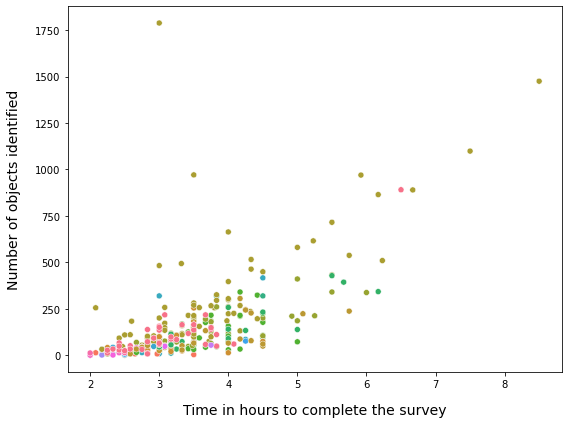

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=som_dims[som_dims.quantity != 'no data'], x='total_time', y='quantity', hue='water_name', palette='husl', ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Time in hours to complete the survey", **xlab_k14 )
ax.set_ylabel("Number of objects identified", **xlab_k14)
plt.tight_layout()
plt.show()

In [14]:
# create an intermediary group
with open(F"{code_defs}/all_foams.json", "r") as a_file:
    foams_bg = json.load(a_file)
with open(F"{code_defs}/sheeting.json", "r") as a_file:
    sheeting_bg = json.load(a_file)
with open(F"{code_defs}/fragmented_plastics.json", "r") as a_file:
    fragplas_bg = json.load(a_file)

the_big_group = ['G27','G30', *foams_bg, *sheeting_bg, *fragplas_bg]

# map codes to descriptions to:
material_map = dfCodes.material
desc_map = dfCodes.description

# make an intermediary group
a_data['big_group'] = 'no group'
a_data.loc[a_data.code.isin(foams_bg), 'big_group'] = 'foams'
a_data.loc[a_data.code.isin(sheeting_bg), 'big_group'] = 'sheeting'
a_data.loc[a_data.code.isin(fragplas_bg), 'big_group'] = 'frag plastic'
a_data.loc[a_data.code.isin(['G27']), 'big_group'] = 'cigarette ends'
a_data.loc[a_data.code.isin(['G30']), 'big_group'] = 'snack wrapper'
a_data.loc[~a_data.code.isin(the_big_group), 'big_group'] = 'other'

# note all records where quantity is > 0
a_data['found'] = a_data.quantity > 0

# <span style="color:#008891">Key indicators of survey results: provide answers to most frequent questions</span>

### <span style="color:#008891">The most frequent questions about the survey data are also key elements in finding sources and areas of accumulation</span>

1. What do you find?
2. How often do you find it?
3. Do you find alot of it?
4. What else do you find?
5. Where do you find the most? 

The indicators should provide reasonable answwers to those questions using parameters that can be taken directly from the survey data.


### <span style="color:#008891">Key indicators to compare survey results between objects, locations and aggregation levels</span>


#### What do you find? How often do you find it? **found rate or fail rate**

There are 76,466 observations from 346 surveys or 221 observations per survey. Objects that were not identified durring a survey have a quantity of 0 for that survey. This allows us to determine how often an object was found. This rate can be calculated at all aggregation levels. The more samples there are at a particular location increases the confidence of the resulting fail rate.

_The fail rate is the number of times that an object was found divided by the number of samples taken._

__what does it mean:__ The fail rate describes how likely you are to find at least one an object in the course of the survey

__how to use it:__ The objects with a high fail rate are those that are most likely to be found at a particular aggregation level

__Why is this important?__ The fail rate alerts us to the presence of items that are identified regularly even though they may not be found in large quantities or the inverse.
<br/><br />

#### Do you find alot of it? Where do you find the most? **pieces per meter**

The pieces per meter ratio is the total number of objects found divided by the length of the survey. This value is calculated automatically at the server and returned as output. This ratio is calculated for each record in the survey. Objects that were not identified durring a survey have a pcs/m ratio of 0.

__what does it mean:__ The pcs-m ratio describes the minimum amount of an object you are likely to find if you mulitply pcs/m by the survey length

__how to use it:__ Objects with high pcs/m ratio have higher minimum value per survey (if they are found: see fail rate)

__Why is this is important?__ A high pcs/m ration indicates either proximity to a source or a zone of accumulation
<br/><br />

#### What else do you find? **percent of total or % of total**

The percent of total describes the value of an object when all the other objects are considered.

__what does it mean:__ The % of total describes how much of the problem can be attributed to an object or group of objects

__how to use it:__ The % of total is the first indicator used to prioritize littering campaigns

__Why is this important:__ This helps define the problem at different levels
<br/><br />



### <span style="color:#008891">Key indicators of the top ten objects</span>

In [15]:

# get the list of codes by quantity
national_topten= a.code_totals.sort_values(ascending=False)

# take first ten records after sorting
national_topten_codes = national_topten.index[:10]

# grab the data from the survey results:
top_ten_national = a_data[a_data.code.isin(national_topten_codes)][['code', 'big_group', 'groupname','quantity', 'found', 'pcs_m', 'loc_date']].copy()

top_ten_national['material'] = top_ten_national.code.map(lambda x: material_map.loc[x])
top_ten_national['description'] = top_ten_national.code.map(lambda x: desc_map.loc[x])

# agg the values from the survey data:
top_ten_agg = top_ten_national.groupby(['code', 'description', 'big_group', 'groupname', 'material'], as_index=False).agg({'pcs_m':'median', 'quantity':'sum', 'found':'sum', 'loc_date':'nunique'})

# calculate the find rate and % of total for each code:
top_ten_agg['find rate'] = top_ten_agg.found/top_ten_agg.loc_date
top_ten_agg['% of total'] = top_ten_agg.quantity/a_data.quantity.sum()

# for display purposes make the description the index
top_ten_agg.set_index('description', inplace=True)

print(F"\nthe top ten codes from all survey data, by quantity:\n\n")
tt_agg = top_ten_agg[['quantity', '% of total', 'find rate', 'pcs_m']].sort_values(by='quantity', ascending=False).round(2)
tt_agg


the top ten codes from all survey data, by quantity:




,quantity,% of total,find rate,pcs_m
description,,,,
Cigarette butts and filters,7560,0.15,0.87,0.20
Foamed polystyrene pieces 0.5cm - 2.5cm,3627,0.07,0.57,0.02
Plastic pieces 0.5cm - 2.5cm,3447,0.07,0.70,0.07
"Food wrappers; candy, snack packaging",3087,0.06,0.85,0.09
Plastic pieces 2.5cm - 50cm,2894,0.06,0.80,0.07
Industrial sheeting,2388,0.05,0.70,0.05
"Glass or ceramic drink bottles, pieces",1828,0.04,0.64,0.03
Foam polystyrene; expanded beads/balls 2.5cm - 50cm,1717,0.03,0.53,0.01
Industrial pellets (nurdles),1664,0.03,0.32,0.00


#### <span style="color:#008891"> How often were the top ten objects found?</span>

The top ten objects from the national data are found at different rates depending on which lake the survey was conducted.

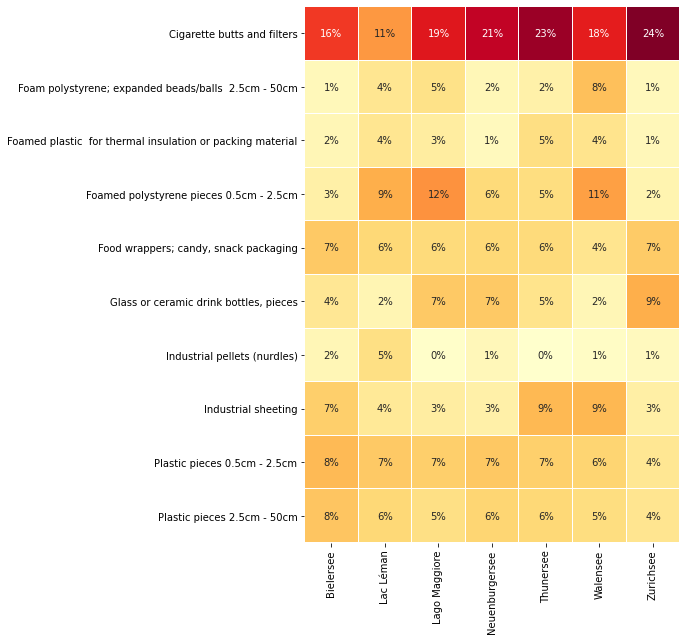

In [16]:
# format data for heat map
rg_tt = a_data[(a_data.code.isin(national_topten_codes))&(a_data.water_name.isin(project_lakes))][['water_name','code', 'quantity', 'found', 'pcs_m', 'loc_date']].groupby(['water_name', 'code'], as_index=False).agg({'quantity':'sum', 'found':'sum', 'pcs_m':'mean', 'loc_date':'nunique'}).copy()

# get the total quantity for each water feature:
w_feat_total = a_data.groupby('water_name').quantity.sum()

# get the remaining key indicators
rg_tt['find rate'] = rg_tt.found/rg_tt.loc_date
rg_tt['feature_total'] = rg_tt.water_name.map(lambda x: w_feat_total.loc[x])
rg_tt['% of total']=rg_tt.quantity/rg_tt.feature_total

# replace the GCODE with a human readable description
rg_tt['description'] = rg_tt.code.map(lambda x: desc_map.loc[x])

# make heat map data
rg_fr = rg_tt[['description', 'water_name', '% of total']].pivot(index='description', columns='water_name')

fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(data=rg_fr, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)


plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">Pieces per meter: the density of the top ten objects for each lake</span>

The top ten objects from the national data are found at different densities depending on which lake the survey was conducted.

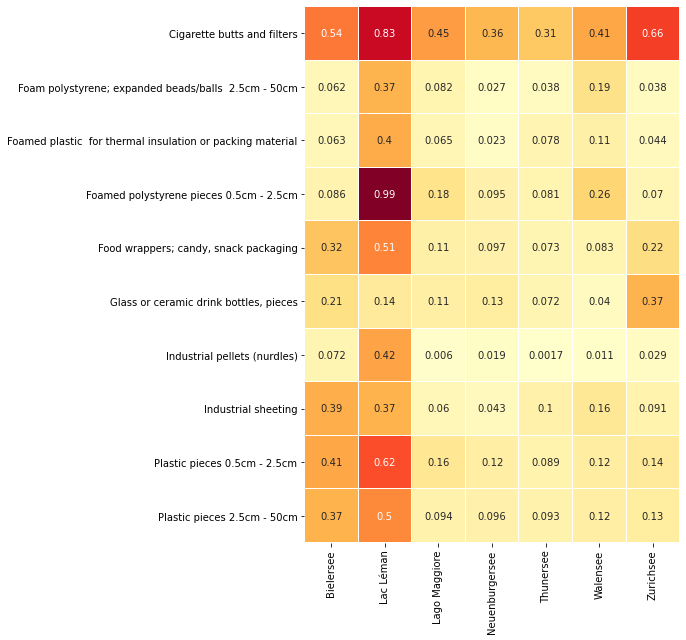

In [17]:

rg_fpcs = rg_tt[['description', 'water_name', 'pcs_m']].pivot(index='description', columns='water_name')


fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(data=rg_fpcs, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".2", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)


plt.tight_layout()

plt.show()
plt.close()

## <span style="color:#008891"> A closer look at the top ten</span>

The top ten group has three members that are foam products. Expanded polystyrene in two sizes and extruded polystyrene. Furthermore, plastic fragements occupy two positions representing the size ranges they are grouped in durring the survey.

#### <span style="color:#008891"> combining like objects</span>

By combining like objects or objects that have the same or similar origin the impact of that group can be better appreciated.

When the foam and the fragmented plastics are combined, that liberates three new places in the top ten list. Foams replace cigarette ends as the most abundant (pcs/m and quantity) but cigarette ends still retain the title as most frequently found.

In [18]:
fts = a_data.groupby(['loc_date','water_name','big_group',], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fts['found'] = fts.quantity > 0

ftsx = fts.groupby('big_group').agg({'pcs_m':'mean', 'quantity':'sum', 'found':'sum', 'loc_date':'nunique'})
ftsx['feature_total'] = ftsx.quantity.sum()
ftsx['find rate'] = ftsx.found/ftsx.loc_date
ftsx['% of total'] = ftsx.quantity/ftsx.feature_total
ftsx['rating'] = ftsx['pcs_m']*ftsx['find rate']

# create a new top ten list that incorporates the results from the intermediary group
# coulmns for grouping and displaying
big_g_cols = ['cigarette ends', 'foams', 'frag plastic', 'sheeting', 'snack wrapper']
concat_cols = ['pcs_m', 'quantity', 'find rate', '% of total']

# get the results from the intermediary group, exclude the 'others' group
fts_s = ftsx.loc[big_g_cols].copy()

# get the code totals for all other objects not in big_goups
cts_s = pd.DataFrame(a.code_totals[~a.code_totals.index.isin(the_big_group)].copy())

# concat the two dfs and sort in descending order 
new_top_ten = pd.concat([fts_s, cts_s], axis=0, ignore_index=False)

# grab the top ten condes in a list
new_top_ten = new_top_ten['quantity'].sort_values(ascending=False)[:10].index

# indentify the new codes that need to be summarized
codes_to_concat = [x for x in new_top_ten if x not in big_g_cols]

# define the pcs_m, quantity, find rate and % of total for the new members of the top ten list
new_tt = a_data[(a_data.code.isin(codes_to_concat))][['code', 'quantity', 'found', 'pcs_m', 'loc_date']].groupby(['code'], as_index=False).agg({'quantity':'sum', 'found':'sum', 'pcs_m':'mean', 'loc_date':'nunique'}).copy()
new_tt['find rate'] = new_tt.found/new_tt.loc_date
new_tt['description'] = new_tt.code.map(lambda x: desc_map.loc[x])
new_tt['% of total'] = new_tt.quantity/a_data.quantity.sum()

# sort the values in descending order and assign index
new_tt_concat = new_tt.sort_values(by='quantity', ascending=False).set_index('description')
ntt_con = new_tt_concat[concat_cols].copy()
fts_con = fts_s[concat_cols].copy()

# combined the two data frames
a_ntt = pd.concat([fts_con, ntt_con], axis=0, ignore_index=False)

#### <span style="color:#008891"> There is more room at the top </span>

In [19]:
a_ntt.sort_values(by='quantity', ascending=False)

,pcs_m,quantity,find rate,% of total
foams,0.826638,8912,0.810345,0.177431
cigarette ends,0.525086,7560,0.870690,0.150514
frag plastic,0.550201,6929,0.862069,0.137951
snack wrapper,0.245690,3087,0.850575,0.061460
sheeting,0.198937,2388,0.704023,0.047543
"Glass or ceramic drink bottles, pieces",0.155661,1828,0.640805,0.036394
Industrial pellets (nurdles),0.132443,1664,0.321839,0.033129
Cotton bud/swab sticks,0.113046,1325,0.511494,0.026380
Plastic construction waste,0.072069,907,0.517241,0.018058
Packaging plastic nonfood or unknown,0.062845,776,0.367816,0.015450


The new additions to the top ten list (cotton swabs, plastic construction waste and non-food packaging) are found more often than industrial pellets but at lesser quantities. Another way to think of it is that there is smaller chance of finding industrial pellets, but when they are found they occur in greater quantities.

In [20]:
# collect all the results for codes in the big_g_cols list
# aggregate to the water feature level
fts_bg = fts[fts.water_name.isin(project_lakes)&(fts.big_group.isin(big_g_cols))].groupby(['water_name', 'big_group'], as_index=False).agg({'quantity':'sum', 'pcs_m':'mean', 'found':'sum', 'loc_date':'nunique'})

# calculate key indicators
fts_bg['find rate'] = fts_bg.found/fts_bg.loc_date
fts_bg['feature_total'] = fts_bg.water_name.map(lambda x: w_feat_total.loc[x] )
fts_bg['% of total'] = fts_bg.quantity/fts_bg.feature_total

# do some housekeeping:
fts_bg.rename(columns={'big_group':'code'}, inplace=True)
fts_bg.set_index('water_name', inplace=True)

In [21]:
# collect all the records in codes_to_concat list
cc_feature = a_data[a_data.code.isin(codes_to_concat)].copy()

# limit only to project lakes and aggregate codes to feature level
cc_feat= cc_feature[cc_feature.water_name.isin(project_lakes)].groupby(['water_name','code',], as_index=False).agg({'pcs_m':'mean', 'quantity':'sum', 'loc_date':'nunique', 'found':'sum' })

# calculate key indicators
cc_feat['find rate'] = cc_feat.found/cc_feat.loc_date
cc_feat['feature_total'] = cc_feat.water_name.map(lambda x: w_feat_total.loc[x] )
cc_feat['% of total'] = cc_feat.quantity/cc_feat.feature_total

# collect the descriptions, replace the code column with descriptions
cc_feat['description'] = cc_feat.code.map(lambda x: desc_map.loc[x])
cc_feat.drop('code', inplace=True, axis=1)
cc_feat.rename(columns={'description':'code'}, inplace =True)

# set index to the same as fts_bg
cc_feat.set_index('water_name', inplace=True)

# concat the two data frames
cc_feat_bg = pd.concat([cc_feat, fts_bg], axis=0, ignore_index=False)

# house keeping
cc_feat_bg = cc_feat_bg[['code',*concat_cols ]].copy()

# get the order of the new df by quantity, descending save the index
index_order = cc_feat_bg.groupby('code').quantity.sum().sort_values(ascending=False).index

# housekeeping
cc_feat_bg.reset_index(inplace=True)

# make heat map data
heat_map_data = cc_feat_bg[['water_name', 'code', '% of total']].pivot(index='code', columns='water_name').sort_values(by=("% of total", "Bielersee"), ascending=False)

# flatten columns
heat_map_data.columns = heat_map_data.columns.get_level_values(1)

# apply the index order
heat_map_data = heat_map_data.reindex(index_order)

#### <span style="color:#008891"> The expanded top ten % of total for each lake</span>

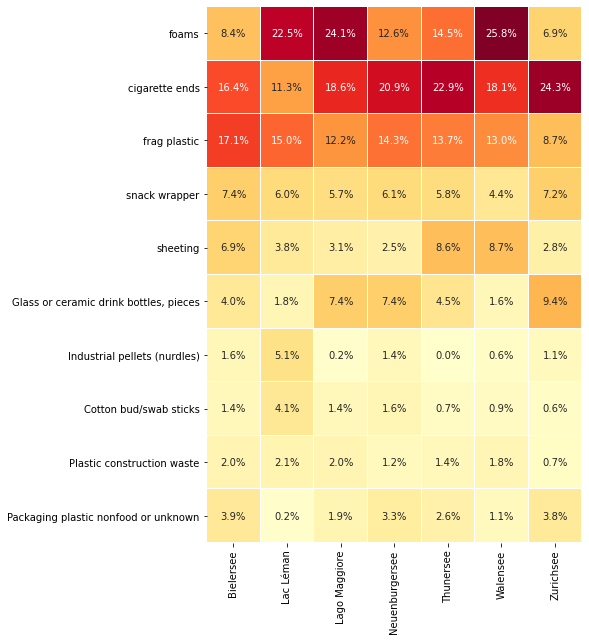

In [22]:
fig, ax = plt.subplots(figsize=(9,9))

sns.heatmap(data=heat_map_data, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".1%", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)

plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">There is a large variety of objects between 1% and 2% of the total</span>

This variety represents the numerous sources of trash in the environment and was the desired result of the sampling method. 

To capture that variety the objects were grouped according to source activity. Fragmented plastics maintain their own group as well as all objects less than 5mm.

Annex A has the complete list and key indicaotrs of all objects found at the national level.



### <span style="color:#008891">The major code groups</span>

The code groups were based on the objects found, the experience of surveyors and discussions with stakeholders from the federal government and NGOS with a long history of monitoring and removing trash from a variety of environments.

__What do code groups mean:__ They describe the __probable__ source activity of an object

__How to use them:__ Identify areas or zones of land use that encourage use of the object

__Why is this important:__ Helps identify sectors or groups that could benefit from outreach

### <span style="color:#008891">Key indicators of the major code groups</span>

Objects related to food consumption replace tobacco products and foams as the most abundant objects. Foams, folded into the construction category, are in 2nd followed by tobacco.

For these larger groups the pcs range (.003 - 0.2) is greater greater than the top ten list ( but the find rates for each group are more consolididated. is remains very similar to the 




In [23]:
# calculate the fail rates at this aggregation level
group_fail_rates = a_data.groupby(['loc_date', 'groupname'], as_index=False).quantity.sum()
group_fail_rates['found'] = group_fail_rates.quantity > 0 
group_fail_rates = group_fail_rates.groupby('groupname').found.sum()

# make a group summary
group_summary = a_data.groupby('groupname').agg({'pcs_m':'mean', 'quantity':'sum',  'loc_date':'nunique'})
group_summary['found'] = group_summary.index.map(lambda x:group_fail_rates.loc[x] )
group_summary['find rate'] = group_summary.found/group_summary.loc_date
group_summary['% of total'] = group_summary.quantity/group_summary.quantity.sum()
group_summary = group_summary[['quantity', 'pcs_m', '% of total', 'find rate']].sort_values(by='quantity',ascending=False)


print("\nThis is the survey results aggregated to groupname for each survey, all locations:\n\n")
group_summary.round(3)


This is the survey results aggregated to groupname for each survey, all locations:




,quantity,pcs_m,% of total,find rate
groupname,,,,
food,9245,0.031,0.184,0.974
construction,9072,0.033,0.181,0.911
tobacco,8333,0.148,0.166,0.920
fragmented plastics,6789,0.202,0.135,0.859
less than 5mm,3902,0.017,0.078,0.514
agg-con-trans,2892,0.017,0.058,0.773
waste water,2470,0.023,0.049,0.667
recreation,2322,0.006,0.046,0.848
packaging,2014,0.012,0.040,0.790


#### <span style="color:#008891"> Fail rate: how often the major code groups were indentified at each lake</span>

Compare the fail rate at the lake level to that of the national level.

In [24]:

# initial aggrgation for this level:
feature_group_summary = a_data[a_data.water_name.isin(project_lakes)].groupby(['water_name','loc_date', 'groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fgs_total = feature_group_summary.groupby('water_name').quantity.sum()

# get the number of failures at this level
feature_group_summary['found'] = feature_group_summary.quantity > 0

# sum up failures, tries and quantity, get the mean value for pcs_m
fgs = feature_group_summary.groupby(['water_name', 'groupname'], as_index=False).agg({'pcs_m':'mean', 'quantity':'sum', 'loc_date':'nunique', 'found':'sum'})

# get some rates
fgs['find rate'] = fgs.found/fgs.loc_date
fgs['feature_total'] = fgs.water_name.map(lambda x: fgs_total.loc[x])
fgs['% of total'] = fgs.quantity/fgs.feature_total
fgs['rating'] = fgs['pcs_m']*fgs['find rate']

# format for the heat map
fgs_rating = fgs[['water_name','groupname','find rate']].round(3).pivot(index='groupname', columns='water_name')
fgs_rating.columns = fgs_rating.columns.get_level_values(1)

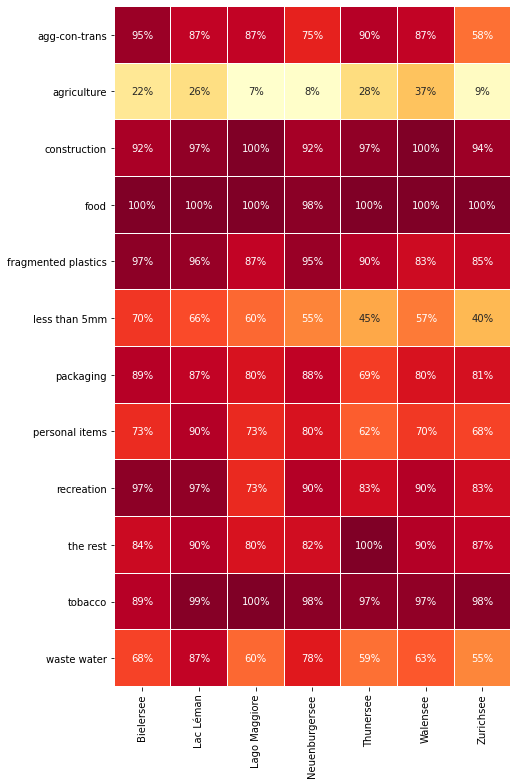

In [25]:
fig, ax = plt.subplots(figsize=(9,11))
sns.heatmap(data=fgs_rating, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)


plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">Pieces per meter: the density of the major code groups for each lake</span>

Compare the fail rate at the lake level to that of the national level.

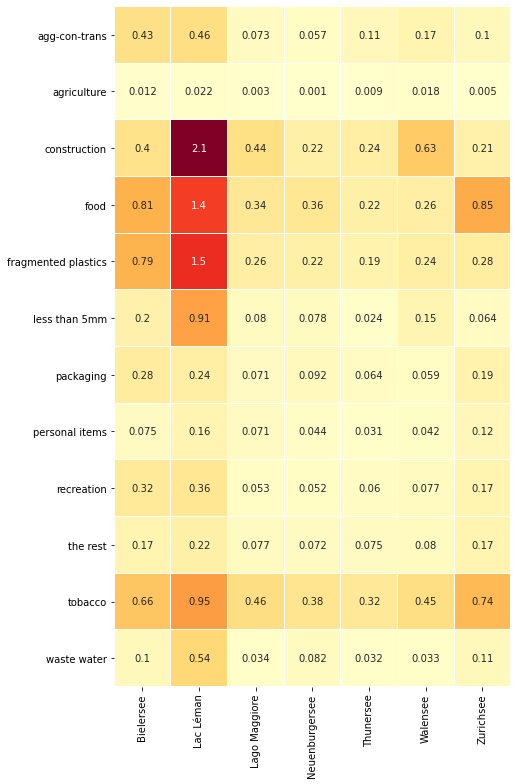

In [26]:
# format for the heat map
fgs_rating = fgs[['water_name','groupname','pcs_m']].round(3).pivot(index='groupname', columns='water_name')
fgs_rating.columns = fgs_rating.columns.get_level_values(1)

fig, ax = plt.subplots(figsize=(9,11))
sns.heatmap(data=fgs_rating, ax = ax, cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".2", cbar=False)

ax.set_ylabel("")
ax.set_xlabel("", loc='left', labelpad=50)
labels = [a_label.get_text().split('-') for a_label in ax.get_xticklabels()]
new_labels = [x[-1] for x in labels]
ax.set_xticklabels(new_labels)


plt.tight_layout()

plt.show()
plt.close()

#### <span style="color:#008891">The top ten results for each water feature</span>

In [27]:
a_group_summary = a_data.groupby('groupname', as_index=False).agg({"quantity":"sum", "pcs_m":"mean"})
a_group_summary['% of total'] = a_group_summary.quantity/a_group_summary.quantity.sum()*100

a_group_summary.round(2)

,groupname,quantity,pcs_m,% of total
0,agg-con-trans,2892,0.02,5.76
1,agriculture,189,0.00,0.38
2,construction,9072,0.03,18.06
3,food,9245,0.03,18.41
4,fragmented plastics,6789,0.20,13.52
5,less than 5mm,3902,0.02,7.77
6,packaging,2014,0.01,4.01
7,personal items,1184,0.00,2.36
8,recreation,2322,0.01,4.62
9,the rest,1816,0.00,3.62


## <span style="color:#008891">For the catchment area: assign code groups, regional labels and daily totals for survey data from the catchment area:</span>

In [28]:

clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    catchment_features=bassin,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=catchment_cols
)



b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

made code groups
making group map
assigned results to code groups
assigned regional labels
assigned results to code groups
assigned regional labels
made code totals
made code totals


In [29]:
som_bassin_data = b.bassin_data.copy()

# mark all the records that have quantity > 0
som_bassin_data['fail'] = som_bassin_data.quantity > 0
som_bassin_data = som_bassin_data[som_bassin_data.columns[1:]]
print(F"\nThe columns from the survey data:\n\n{som_bassin_data.columns}\n")


The columns from the survey data:

Index(['code', 'pcs_m', 'quantity', 'location', 'loc_date', 'water_name',
       'type', 'groupname', 'population', 'string_date', 'region', 'city',
       'fail'],
      dtype='object')



#### <span style="color:#008891">Get the dimensional data for the catchment area:</span>

### <span style="color:#008891"> Get sample rates at the code level:</span>

In [30]:
# map number of samples per location and sample total to each record

def add_attribute(x, a_map={}):
    try:
        num_samps = a_map[x]
    except:
        num_samps = 0
    return num_samps

# conut the number of samples per location
num_samp_location = b.bassin_pcsm_day.groupby('location').loc_date.count()

# retrieve the total quantity per sample
qty_sample = b.bassin_pcsm_day.groupby('loc_date').quantity.sum()

In [31]:
# map values to bassin data

# the number of samples at a location
for beach in som_bassin_data.location.unique():
    som_bassin_data.loc[som_bassin_data.location==beach, 'nsamps'] = add_attribute(beach, a_map=num_samp_location)

# the number of samples at a location divided by the total number of samples
# som_bassin_data['l_weight'] = som_bassin_data.nsamps/len(som_bassin_data.loc_date.unique())

# the survey total for the corresponding loc_date variable
for loc_date in som_bassin_data.loc_date.unique():
    som_bassin_data.loc[som_bassin_data.loc_date==loc_date, 'samp_total'] = qty_sample[[loc_date]][0]

# the % of total for that object for the survey defined by loc_date
som_bassin_data['sample_% _of_total'] = som_bassin_data.quantity/som_bassin_data.samp_total

In [32]:
def save_describe(x):
    data=x.describe()
    return data.values

# save the key values from the original data:
q_before = save_describe(som_bassin_data.quantity)
pc_befor = save_describe(som_bassin_data.pcs_m)
print(som_bassin_data.quantity.sum())

12884


In [33]:
# rank the quantity found of each code in each survey for all locations
ranked = []

# the loc_date values to aggregate:
locs = som_bassin_data.loc_date.unique()

# for each value in loc_date:
sbd = som_bassin_data.copy()
for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd[sbd.loc_date == a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['sample_rank'] = sbdl.index
    ranked.append(sbdl)
    
# new data with amplitude rankings for each record
sbd = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print(q_before == sbd.quantity.describe().values)
print(sbd.quantity.sum())
print(pc_befor == sbd.pcs_m.describe().values)


[ True  True False  True  True  True  True  True]
12884
[ True  True  True  True  True  True  True  True]


In [34]:
sbd.columns

Index(['code', 'pcs_m', 'quantity', 'location', 'loc_date', 'water_name',
       'type', 'groupname', 'population', 'string_date', 'region', 'city',
       'fail', 'nsamps', 'samp_total', 'sample_% _of_total', 'sample_rank'],
      dtype='object')

In [35]:
sbd.head()

,code,pcs_m,quantity,location,loc_date,water_name,type,groupname,population,string_date,region,city,fail,nsamps,samp_total,sample_% _of_total,sample_rank
0,G27,0.57,60,weissenau-neuhaus,"(weissenau-neuhaus, 2021-03-09)",Thunersee,l,tobacco,5751.0,2021-03-09,Aare,Unterseen,True,11.0,238.0,0.252101,1
1,G78,0.27,28,weissenau-neuhaus,"(weissenau-neuhaus, 2021-03-09)",Thunersee,l,fragmented plastics,5751.0,2021-03-09,Aare,Unterseen,True,11.0,238.0,0.117647,2
2,G74,0.18,19,weissenau-neuhaus,"(weissenau-neuhaus, 2021-03-09)",Thunersee,l,construction,5751.0,2021-03-09,Aare,Unterseen,True,11.0,238.0,0.079832,3
3,G67,0.15,16,weissenau-neuhaus,"(weissenau-neuhaus, 2021-03-09)",Thunersee,l,agg-con-trans,5751.0,2021-03-09,Aare,Unterseen,True,11.0,238.0,0.067227,4
4,G941,0.14,15,weissenau-neuhaus,"(weissenau-neuhaus, 2021-03-09)",Thunersee,l,packaging,5751.0,2021-03-09,Aare,Unterseen,True,11.0,238.0,0.063025,5


In [36]:
# the top ten for the catchment area:
catchment_top_ten = sbd.groupby('code').quantity.sum().sort_values(ascending=False)
print(F"\n objects grouped by code and sorted by quantity found:\n\n{catchment_top_ten[:10]}\n")


 objects grouped by code and sorted by quantity found:

code
G27     2412
G78      994
G79      844
G30      842
G67      781
G200     643
G81      559
G941     400
G117     285
G74      284
Name: quantity, dtype: int64



In [37]:
print("\n objects grouped by code and sorted by median pcs-m: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).pcs_m.median().sort_values(ascending=False)[:10]


 objects grouped by code and sorted by median pcs-m: 




code
G122    0.580
G144    0.235
G27     0.190
G78     0.155
G119    0.135
G79     0.100
G5      0.090
G30     0.090
G67     0.090
G200    0.080
Name: pcs_m, dtype: float64

In [38]:
print("\n objects grouped by code and sorted by quantity found: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).quantity.sum().sort_values(ascending=False)[:10]


 objects grouped by code and sorted by quantity found: 




code
G27     2412
G78      994
G79      844
G30      842
G67      781
G200     643
G81      559
G941     400
G117     285
G74      284
Name: quantity, dtype: int64

In [39]:
print("\n objects grouped by code and sorted by number of times at least one was found: \n\n")
sbd[sbd.quantity > 0].groupby(['code']).fail.sum().sort_values(ascending=False)[:10]


 objects grouped by code and sorted by number of times at least one was found: 




code
G27     107
G79     107
G30     105
G67      97
G78      96
G200     87
G81      72
G82      68
G74      64
G89      64
Name: fail, dtype: int64

### Sample rank: how much of the sample total was taken up by this object analogous to % of sample total

In [40]:
print("\n objects grouped by water feature and code, sorted by frequency of sample ranking: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name','code', 'sample_rank'], as_index=False).loc_date.nunique().sort_values(by='loc_date', ascending=False)


 objects grouped by water feature and code, sorted by frequency of sample ranking: 




,water_name,code,sample_rank,loc_date
1394,Neuenburgersee,G27,1,22
2054,Thunersee,G27,1,12
1581,Neuenburgersee,G79,3,11
1291,Neuenburgersee,G200,2,9
483,Bielersee,G27,1,9
...,...,...,...,...
840,Bielersee,G928,23,1
839,Bielersee,G928,22,1
838,Bielersee,G928,21,1
837,Bielersee,G928,12,1


In [41]:
print("\n objects grouped by water feature and code, sorted by quantity found: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name','code'], as_index=False).quantity.sum().sort_values(by='quantity', ascending=False)


 objects grouped by water feature and code, sorted by quantity found: 




,water_name,code,quantity
377,Neuenburgersee,G27,898
155,Bielersee,G27,719
537,Thunersee,G27,613
188,Bielersee,G78,371
189,Bielersee,G79,334
...,...,...,...
306,La Thièle,G67,1
307,La Thièle,G81,1
308,La Thièle,G82,1
313,Neuenburgersee,G103,1


In [42]:
print("\n objects grouped by water feature and code, sorted by median pcs_m: \n\n")
sbd[sbd.quantity > 0].groupby(['water_name','code'], as_index=False).pcs_m.median().sort_values(by='pcs_m', ascending=False)


 objects grouped by water feature and code, sorted by median pcs_m: 




,water_name,code,pcs_m
259,Brienzersee,G27,1.00
66,Aare,G98,0.97
278,Brienzersee,G78,0.61
144,Bielersee,G204,0.59
98,Bielersee,G122,0.58
...,...,...,...
489,Thunersee,G124,0.01
485,Thunersee,G111,0.01
482,Thunersee,G103,0.01
312,Neuenburgersee,G102,0.01


### Get sample rates at the group level:

In [43]:
def calculate_fail(x):
    a_q = x.sum()
    if a_q > 0:
        data = True
    else:
        data = False
    return data

In [44]:
sbd_g = sbd.groupby(['water_name', 'type', 'loc_date', 'date', 'location', 'groupname', 'nsamps', 'samp_total'], as_index=False).agg({'quantity':'sum', 'pcs_m':'sum', 'fail':calculate_fail})

sbd_g_ranked = []
for a_samp in locs:
    # sort the values for each survey by 
    sbdl = sbd_g.loc[sbd_g.loc_date==a_samp].sort_values(by='quantity', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['sample_rank'] = sbdl.index
    sbd_g_ranked.append(sbdl)
sbd_g_ranked[0]
sbd_gr = pd.concat(sbd_g_ranked, ignore_index=True)
sbd_gr.head()

KeyError: 'date'

In [ ]:
fd = sbd_gr[(sbd_gr.water_name=='Bielersee')&(sbd_gr.sample_rank==1)].groupby('groupname').sample_rank.sum()
fd.sum()
print(fd)

In [ ]:
sbd_gr[sbd_gr.water_name == 'Aare'].groupby(['water_name','groupname', 'sample_rank'], as_index=False).loc_date.nunique()

In [ ]:
other_number_one_ranks = rank_and_code[rank_and_code['rank'] == 1].groupby(['code','location'], as_index=False).n_times.sum()
print(F"Codes and the number of times that they have been the number one item at a survey\n{other_number_one_ranks.groupby('code').n_times.sum().sort_values(ascending=False)}")

In [ ]:
# project directory is 'output/bielsummary'
sbd_ranked.to_csv(F"{project_directory}/aare_codes_ranked.csv")

In [ ]:
these_codes = ['G27', 'G30','G25', 'G81', 'G95', 'G67','G82']

In [ ]:
# grouped by survey and code group
sbd_ranked_gs = som_bassin_data.groupby(['loc_date','groupname','location', 'population'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

sbd_ranked_gs['% of total'] = sbd_ranked_gs.apply(lambda x: x.quantity/qty_sample[x.loc_date], axis=1)
# save the key values from the original data:
q_before = save_describe(sbd_ranked_gs.quantity)
pc_befor = save_describe(sbd_ranked_gs.pcs_m)
print(sbd_ranked_gs.quantity.sum())

In [ ]:
ranked = []
for a_samp in locs:
    sbdl = sbd_ranked_gs[sbd_ranked_gs.loc_date == a_samp].sort_values(by='% of total', ascending=False)
    sbdl = sbdl.set_index(np.arange(1, len(sbdl)+1), drop=True)
    sbdl['rank'] = sbdl.index
    ranked.append(sbdl)
    
sbd_ranked_gs = pd.concat(ranked, ignore_index=True)

# check the key values before and after:
print("Check that the survey values have not been altered:\n")
print(q_before == sbd_ranked_gs.quantity.describe().values)
print(pc_befor == sbd_ranked_gs.pcs_m.describe().values)

# check the % of total
print(F"\nCheck % of total: {sbd_ranked_gs.groupby('loc_date')['% of total'].sum().sum()}\n")
print(F"The number of SURVEYS where ALL TOBACCO items combined are rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()}\n")

print(F"All TOBACCO items combined were number one in {np.round((sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].loc_date.nunique()/sbd_ranked_gs.loc_date.nunique())*100,0)}% of the surveys.")
print(F"\nThe number of locations that tobaco is rank one: {sbd_ranked_gs[(sbd_ranked_gs.groupname == 'tobacco')&(sbd_ranked_gs['rank'] == 1)].location.nunique()}\n")
print(F"The objects labeled tobacco:\n{sbd_ranked[sbd_ranked.groupname == 'tobacco'].code.unique()}")

In [ ]:
f = sbd_ranked_gs.groupby(['rank','groupname','location'], as_index=False).loc_date.nunique()
fx = f[f['rank'] == 1].groupby('groupname').loc_date.sum()
print(F"\nThe number of samples: {fx.sum()}\n")
print(F"Other groups and the number of times they have been the most prevalent item:\n{fx.sort_values(ascending=False)}\n")

In [ ]:
# get the pass fail rate for each water feature

# the total number of tries:
tries_t = som_bassin_data.groupby(['water_name', 'code']).loc_date.nunique()

# the total number of times that the object was found for a particular water feature
fails_b = som_bassin_data.groupby(['water_name','code']).fail.sum()

# the total number of samples:
n_samps_b = som_bassin_data.groupby(['water_name']).loc_date.nunique()

In [ ]:
# get all values greater than zero for each code and LOCATION
grtr_than_zero = som_bassin_data[(som_bassin_data.quantity > 0)].groupby(['code', 'location'], as_index=False).loc_date.count()

# weight the result by the sum of the loc_date column
grtr_than_zero['weight'] = grtr_than_zero.loc_date/grtr_than_zero.loc_date.sum()

# housekeeping
som_data = som_bassin_data.copy()

# get a list of the codes that were found at least once
codes_in_use = grtr_than_zero.code.unique()

In [ ]:
# combine the tries and fails dfs for each water feature
tries_fails_b = pd.concat([tries_t, fails_b], axis=1)
tries_fails_b.reset_index(inplace=True)

In [ ]:
tries_fails_b.iloc[:3]

In [ ]:
# get the ratio of total tries per code and location to total number of samples for that feature
for a_b in tries_fails_b.water_name.unique():
    tries_fails_b.loc[tries_fails_b.water_name==a_b, 'rate'] = tries_fails_b.fail/n_samps_b.loc[a_b]

tries_fails_b.iloc[:3]

In [ ]:
# the minimum rate is 1/ the current sample number + 1
# we are assuming that if the object has never been found before there
# is always a chance that we may find it on the next sample
# the longer we go without finding it the less likely it is to find in the river basin
# which means that once it has been identified this should be considered a significant event.
rate_min = 1/(len(a.processed.loc_date.unique())+1)
rate_min

In [ ]:
tries_fails_b.loc[tries_fails_b.fail==0, 'min_rate'] = rate_min
tries_fails_b.loc[tries_fails_b.fail>0, 'min_rate'] = tries_fails_b.rate
tries_fails_b.iloc[:3]

In [ ]:
# get the ratio samples-per-location/number-samples-catchment-area
weights = tries_fails_b[['water_name', 'loc_date']].drop_duplicates().set_index('water_name', drop=True)
weights['location_weight'] = weights.loc_date/len(locs)
nsamps = weights.loc['Aare', :]

# now the number of samples and the weight is available
nsamps

In [ ]:
# pull some samples from one river basin feature
feature = 'Aare'
n = weights.loc['Aare', 'loc_date']
rates = tries_fails_b.loc[tries_fails_b.water_name == 'Aare'][['code','min_rate']].set_index('code')

# store the samples here
theta_samples_feature = pd.DataFrame(index=codes_in_use)

In [ ]:
rates.loc['G27'].values

In [ ]:
# determine wehter or not an object was found at a survey
# use the rates for the parameter of a bernouli trial for each code

k=0
for j in np.arange(n):
    k+=1
    col_name = F"s_{int(k)}"
    for a_code in codes_in_use:
        theta_samples_feature.loc[a_code, col_name ] = bernoulli.rvs(rates.loc[a_code], size=1)


found_feature = theta_samples_feature > 0
codes_found_feature = [found_feature[found_feature[s_one] == True][s_one].index for s_one in found_feature.columns]
codes_found_len_feature = [len(x) for x in codes_found_feature]

In [ ]:
d_samps_aare = b.bassin_data[(b.bassin_data.quantity>0)&(b.bassin_data.water_name == "Aare")][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [ ]:
# get the number of times each code was found
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
theta_codes_count = count_occurences(codes_found_feature)
dsamp_aare_count = pd.DataFrame(count_occurences(d_samps_aare)).set_index('code')

In [ ]:
dsamp_aare_count.loc['G7', 'inst']

In [ ]:
# combine the counts in to one dataframe and compare results

def combine_code_counts(x):
    try:
        data = dsamp_aare_count.loc[x, 'inst']
    except:
        data = 0
    return data
        
theta_codes = pd.DataFrame(theta_codes_count)
theta_codes['s_inst'] = theta_codes.code.map(lambda x: combine_code_counts(x))
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

# check the diffference between the two sets
print(theta_codes['s_inst'].sum())
print(theta_codes['inst'].sum())
print(theta_codes.inst_dif.sum())
print(len(theta_codes))

In [ ]:
theta_codes[theta_codes.code.isin([x for x in theta_codes.code.unique() if x not in dsamp_aare_count.index])]

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(12,8))
sns.barplot(data=theta_codes.sort_values(by='s_inst', ascending=False), x='code', y='s_inst', ax=axs[0])
sns.barplot(data=theta_codes.sort_values(by='inst', ascending=False), x='code', y='inst', ax=axs[1])
axs[0].tick_params(axis='x', labelrotation=90, labelsize=8)
axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

In [ ]:
theta_samples_all = pd.DataFrame(index=codes_in_use)
tries = som_bassin_data.groupby(['code']).loc_date.nunique()
fails = som_bassin_data.groupby('code').fail.sum()
# tries_fails by water body

# for one body of water
#fails_b = som_bassin_data.groupby(['water_name','code']).fail.sum()

tries_fails = pd.concat([tries, fails], axis=1)
tries_fails['rate'] = tries_fails.fail/tries_fails.loc_date

code_weights = grtr_than_zero.groupby('code').weight.sum()

In [ ]:
k = 0
for body in weights.index:
#     print(body)
#     print(tries_fails_b.loc[body].min_rate.sum())
    these_rates =tries_fails_b.loc[tries_fails_b.water_name == body][['code','min_rate']].set_index('code')
    

    for j in np.arange(weights.loc[body]['loc_date']):
        k+=1
        #print(j, k)
        col_name = F"s_{int(k)} {body}"
        for a_code in codes_in_use:
            theta_samples_all.loc[a_code, col_name ] = bernoulli.rvs(these_rates.loc[a_code], size=1)
#             theta_samples_all.loc[a_code, col_name ] = binom.rvs(1,these_rates.loc[a_code], size=1)
            

In [ ]:
found = theta_samples_all > 0
codes_found = [found[found[s_one] == True][s_one].index for s_one in found.columns]
codes_found_len = [len(x) for x in codes_found]

print(len(codes_found[0]))
print(codes_found_len[0])
print(len(codes_found))

In [ ]:
tries_fails.iloc[:3]

In [ ]:
# the number of unique codes per sample in the project data:
d_samps = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.nunique()

# the list of codes found at each survey in the project data:
d_samps_c = b.bassin_data[b.bassin_data.quantity>0][['loc_date', 'code']].groupby('loc_date').code.unique().to_numpy()

In [ ]:
def count_occurences(an_array):
    wiw = {}
    for a_list in an_array:
        for code in a_list:
            if code in wiw.keys():
                wiw[code] += 1
            else:
                wiw[code] = 1
    return [{'code':k, 'inst':v} for k,v in wiw.items()]
samp_codes = pd.DataFrame(count_occurences(d_samps_c)).set_index('code')


In [ ]:
# a_list_o_list = [value for k, value in samples.items()]
# the_list_o_list = [*a_list_o_list]
theta_codes = pd.DataFrame(count_occurences(codes_found))
theta_codes['s_inst'] = theta_codes.code.map(lambda x: samp_codes.loc[x, 'inst'])
theta_codes['inst_dif'] = theta_codes.inst - theta_codes.s_inst

In [ ]:
print(theta_codes['inst_dif'].sum())
print(len(theta_codes))
print(theta_codes.inst.sum(), theta_codes.s_inst.sum())

In [ ]:
fig, axs = plt.subplots(figsize=(18,8))
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='s_inst', ascending=False), x='code', y='s_inst', color='red', alpha=.6, ax=axs)
sns.barplot(data=theta_codes[theta_codes.inst >=20].sort_values(by='inst', ascending=False), x='code', y='inst', color='blue',alpha=.6, ax=axs)
axs.tick_params(axis='x', labelrotation=90, labelsize=10)
# axs[1].tick_params(axis='x', labelrotation=90, labelsize=8)
plt.show()
plt.close()

In [ ]:

fig, axs = plt.subplots(1,2)
sns.histplot(codes_found_len, ax=axs[0], binwidth=3)
sns.histplot(d_samps.values, ax=axs[1], binwidth=3)
plt.show()
plt.close()

In [ ]:
# found.rename(columns={x:x.split(" ")[-1] for x in found.columns}, inplace=True)
codes_found = [{'label':s_one.split(" ")[-1] , 'codes':found[found[s_one] == True][s_one].index.to_numpy()} for s_one in found.columns]
# codes_found_len = [len(x) for x in codes_found_feature]
a_label = codes_found[1]['label']
a_code = codes_found[1]['codes'][0]

In [ ]:
location_weight = som_bassin_data.groupby('water_name', as_index=False).l_weight.median()
location_weight.loc[4, 'water_name'] = "Thièle"

In [ ]:
agg_results_feature = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['water_name','code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_feature.columns = agg_results_feature.columns.get_level_values(1)
agg_results_bassin = som_bassin_data[som_bassin_data.pcs_m > 0].groupby(['code']).agg({'pcs_m':['mean', 'min', 'median', 'max']})
agg_results_bassin.columns = agg_results_bassin.columns.get_level_values(1)
# get the parameters for one code at one sample:
this_data = agg_results_feature.loc[a_label,codes_found[1]['codes'][0]]
print(this_data['mean'])
print(codes_found[1]['codes'][0])
print(a_label)
loc = this_data['mean']
alpha=this_data['min']
beta = 1/alpha
print("\n the parameters \n")
print(loc, alpha, beta)

print("\nthe predicted result \n")
print(gamma.rvs(alpha, loc=loc, scale=beta))

In [ ]:
agg_results_feature.loc['Aare','G101']['min']

In [ ]:
# hmm = pd.DataFrame(codes_found).explode('codes').copy()
# hmm.drop_duplicates(inplace=True)
# print(hmm.isnull().values.any())
# hmm.reset_index(inplace=True, drop=True)

In [ ]:
def assign_params(a_label, a_code, a_param, params):
    default_params = agg_results_bassin
    try:
        this_param = params.loc[a_label,a_code][a_param]
    except:
        this_param = default_params.loc[a_code][a_param]
    return this_param
    

In [ ]:
o_samps_d = b.bassin_pcsm_day[['water_name', 'pcs_m']].sort_values(by='pcs_m')
o_samps_d.reset_index(inplace=True, drop=True)
o_samps_d

In [ ]:
location_weight.set_index('water_name', drop=True, inplace=True)


In [ ]:
location_weight

In [ ]:
sim_surveys = []
for i,sample in enumerate(codes_found):
    a_label = sample['label']
    som_codes = sample['codes']
    loc_weight = location_weight.loc[a_label]
    for a_code in som_codes:
        alpha = assign_params(a_label, a_code, 'median', agg_results_feature)
        loc = assign_params(a_label, a_code, 'min', agg_results_feature)
        scale = assign_params(a_label, a_code, 'max', agg_results_feature)+(5*alpha)       
        pcs_m = gamma.rvs(alpha+(loc_weight*alpha), loc=loc, scale=scale)
        sim_surveys.append({'code':a_code, 'label':a_label, 'survey':i, 'pcs_m':pcs_m})
    
new_surveys = pd.DataFrame(sim_surveys)
new_surveys_d = new_surveys.groupby(['survey','label'], as_index=False).pcs_m.sum().copy()

new_surveys_d.sort_values(by='pcs_m', inplace=True)
ns_d = new_surveys_d[['label', 'pcs_m']].reset_index(drop=True).copy()
ns_d.rename(columns={'label':'water_name'}, inplace=True)
ns_d['label'] = 'sim'
o_samps_d['label'] = 'odata'
o_samps_d['survey'] = o_samps_d.index
ns_d['survey'] =ns_d.index

In [ ]:
o_samps_d['label'] = 'odata'

combined = pd.concat([ns_d, o_samps_d])

In [ ]:
combined

In [ ]:
fig, axs = plt.subplots(figsize=(14,8))
sns.scatterplot(data=combined, x='survey', y='pcs_m', style='label', hue='water_name', palette='husl', s=40, ax=axs)
# sns.scatterplot(data=o_samps_d, x=o_samps_d.index, y=o_samps_d.pcs_m, hue=o_samps_d.water_name, palette='viridis', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()

In [ ]:
# get the values for one survey:
fig, axs = plt.subplots(figsize=(14,8))
sns.boxplot(data=combined, x='water_name', y='pcs_m', hue='label', palette='flare', ax=axs, dodge=True)
sns.stripplot(data=combined, x='water_name', y='pcs_m', hue='label', palette='husl', ax=axs)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.close()


In [ ]:
hmm

In [ ]:
these_params = []

# get some paramaters from the data.
print("The codes and the number of samples that the parameters are being drawn from\n")
for code in samples[0]:
    samp_data = som_params[som_params.code == code].pcs_m
    # check how many samples there are for this region/district
    # if less than minsamps grab the results from the next highest level
    minsamps = 65
    if len(samp_data) < minsamps:
        samp_data = a.processed[(a.processed.code == code)&(a.processed.quantity > 0)].pcs_m
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    else:
        loc = samp_data.min()
        alpha = samp_data.mean()
        scale = 1/alpha
    print(code, len(samp_data))
    these_params.append(dict(code=code, loc=loc, alpha=alpha, scale=scale, data=samp_data))


In [ ]:
these_params[2]['data'].sum()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch